## ENSEMBLE LEARNING
LOGISTIC REGRESSION (BASE LEARNER)
XGBOOST (META LEARNEER)

### Load Pre-Trained Models and Vectorizers

In [13]:
import pickle
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import pandas as pd

# Load the Logistic Regression model and vectorizer
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

# Load the XGBoost model, label encoder, and TF-IDF vectorizer
with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)


### Prepare the Dataset for Testing

In [14]:
# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' column exists
if 'cleaned_text' not in data.columns:
    raise ValueError("The dataset must have a 'cleaned_text' column.")

# Remove rows with missing values in 'cleaned_text'
data.dropna(subset=['cleaned_text'], inplace=True)

# Split features and target
X_test = data['cleaned_text']
y_test = data['mental_health_issue']

# Encode target labels
y_test = label_encoder.transform(y_test)

# Transform the text using the respective vectorizers
X_test_lr = lr_vectorizer.transform(X_test)  # Logistic Regression vectorizer
X_test_xgb = tfidf_vectorizer.transform(X_test)  # XGBoost vectorizer


### Stack Predictions for Ensemble

In [15]:
import numpy as np

# Get predictions from the base models
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)

# Combine predictions as new features
stacked_features = np.hstack((lr_predictions_proba, xgb_predictions_proba))


In [16]:
print(type(lr_model))
print(type(xgb_model))


<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'xgboost.sklearn.XGBClassifier'>


### Train a Meta-Learner

In [19]:
# Train meta-learner using combined features (optional step if not pre-trained)
X_train_meta, y_train_meta = stacked_features, y_test  # Example using test data as meta-training data

meta_learner = LogisticRegression(max_iter=5000)
meta_learner.fit(X_train_meta, y_train_meta)

# Save the trained meta-learner
with open('meta_learner.pkl', 'wb') as file:
    pickle.dump(meta_learner, file)


### Make Predictions

In [20]:
from sklearn.metrics import confusion_matrix

# Load the pre-trained meta-learner
with open('meta_learner.pkl', 'rb') as file:
    meta_learner = pickle.load(file)

# Predict using the meta-learner
final_predictions = meta_learner.predict(stacked_features)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, final_predictions)
report = classification_report(y_test, final_predictions, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, final_predictions))

Accuracy: 96.09%
Classification Report:
               precision    recall  f1-score   support

     anxiety       0.96      0.93      0.95      1999
     bipolar       0.90      0.86      0.88      1941
  depression       0.95      0.94      0.94      1959
      normal       0.97      0.99      0.98     10679
        ptsd       0.98      0.95      0.96      1987

    accuracy                           0.96     18565
   macro avg       0.95      0.93      0.94     18565
weighted avg       0.96      0.96      0.96     18565

Confusion Matrix:
 [[ 1868    34    35    42    20]
 [   10  1661    29   232     9]
 [   34    45  1839    24    17]
 [    5    73     5 10594     2]
 [   22    23    33    31  1878]]


### Confusion Matrix

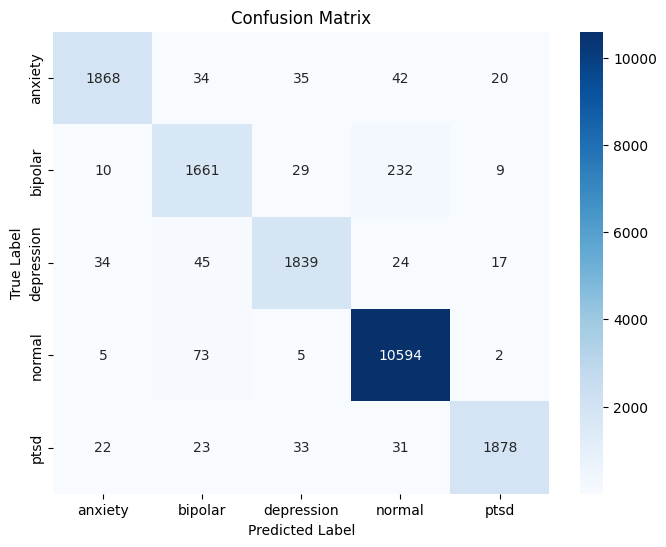

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### ROC AUC Curve

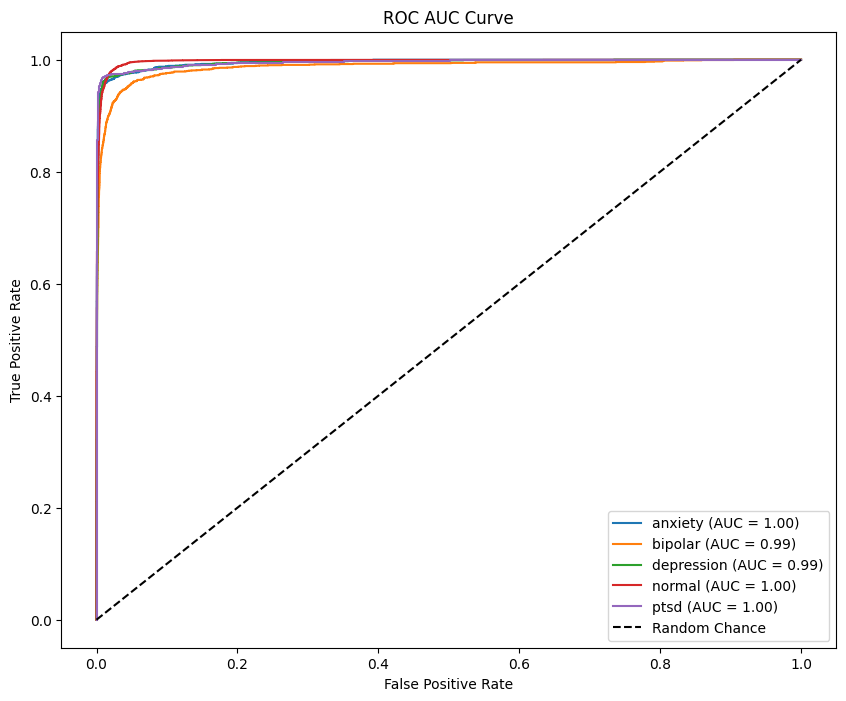

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
final_predictions_proba = meta_learner.predict_proba(stacked_features)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], final_predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()
